This code gets the flux ratio with different a4<br>
The first parts of the code is from the tutorial code, which can be found at:<br>
https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/LensModeling/modeling_a_quadruply_imaged_quasar.ipynb

% importing<br>
some python imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

% Setting Up

data specifics

In [3]:
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF 

PSF specification

In [4]:
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

list of light profiles (for lens and source)<br>
'SERSIC': spherical Sersic profile

In [5]:
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light_1 = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0,
                 'e1': -0.1, 'e2': 0.01}
kwargs_lens_light = [kwargs_lens_light_1]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

'SERSIC_ELLIPSE': elliptical Sersic profile

In [6]:
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0., 0.1
kwargs_source_1 = {'amp': 4000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_source_1]
source_model_class = LightModel(light_model_list=source_model_list)

% Define a function to calculate (1) the lensed position and (2) the magnification with different lens setup

Lens specification

In [7]:
def my_epl_boxydisky_lens_model(a_m, e1=0.1, e2=0.2):
    lens_model_list = ['EPL_BOXYDISKY', 'SHEAR']
    gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
    kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}
    kwargs_epl_boxydisky = {'theta_E': 1., 'a_m': a_m, 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': e1, 'e2': e2}
    kwargs_lens = [kwargs_epl_boxydisky, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list)
    return lens_model_class, kwargs_lens

In [8]:
def my_epl_boxydisky_x_y_mag(a_m, e1=0.1, e2=0.2):
    lens_model_class, kwargs_lens = my_epl_boxydisky_lens_model(a_m, e1, e2)
    # Solver setting for finding where the lensed images are
    lensEquationSolver = LensEquationSolver(lens_model_class)
    x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                          min_distance=deltaPix, search_window=numPix * deltaPix)
    assert len(x_image) == 4 # Check if there are four images

    # compute lensing magnification at image positions
    mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
    mag = np.abs(mag)  # ignore the sign of the magnification
    return x_image, y_image, mag

In [9]:
def my_epl_boxydisky_data(data_class, a_m, e1=0.1, e2=0.2, noise=False):
    lens_model_class, kwargs_lens = my_epl_boxydisky_lens_model(a_m, e1, e2)
    x_image, y_image, mag = my_epl_boxydisky_x_y_mag(a_m, e1, e2)
    # # perturb observed magnification due to e.g. micro-lensing
    # mag_pert = np.random.normal(mag, 0.5, len(mag))
    point_amp = mag * 100  # multiply by intrinsic quasar brightness (in counts/s)
    kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                  'point_amp': point_amp}]  # quasar point source position in the source plane and intrinsic brightness

    # note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
    # you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.
    point_source_list = ['LENSED_POSITION']
    point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                            lens_light_model_class,
                            point_source_class, kwargs_numerics=kwargs_numerics)
    image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
    if noise:
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim + bkg + poisson
    else:
        pass
    kwargs_data['image_data'] = image_sim
    data_class.update_data(image_sim)
    # plt.matshow(np.log10(image_sim), origin='lower')
    # plt.show()
    return data_class, image_sim, x_image, y_image, mag

% Test different a_m

In [10]:
a_m_arr = np.linspace(-0.01, +0.01, 100)
mag_arr = np.zeros([len(a_m_arr), 4])
x_image_arr = np.zeros([len(a_m_arr), 4])
y_image_arr = np.zeros([len(a_m_arr), 4])

In [11]:
for i, a_m in enumerate(a_m_arr):
    x_image, y_image, mag = my_epl_boxydisky_x_y_mag(a_m)
    mag_arr[i] = mag
    x_image_arr[i] = x_image
    y_image_arr[i] = y_image

Standard data without boxy/diskyness

In [12]:
x_image_noboxydisky, y_image_noboxydisky, mag_noboxydisky = my_epl_boxydisky_x_y_mag(0.)
fr_noboxydisky = mag_noboxydisky[1:]/mag_noboxydisky[0]

% Plotting<br>
Color Setting

In [13]:
color_arr = np.array([[0,0,0],[1,0.5,0.5],[1,0.75,0.5],[0.5,0.75,0.5]])

magnification itself

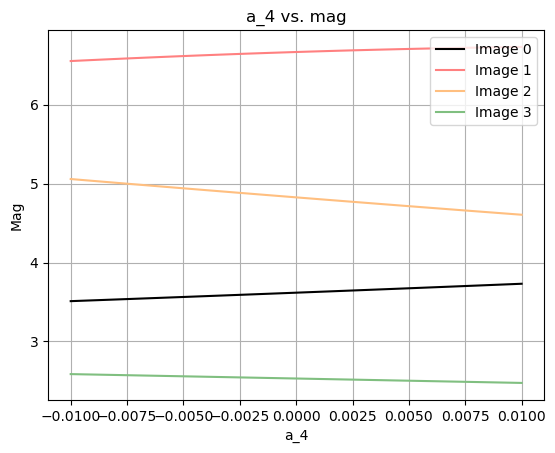

In [14]:
plt.figure()
plt.grid(True)
for i in range(4):
    plt.plot(a_m_arr, mag_arr[:,i], label='Image %d'%(i), color=color_arr[i])
plt.xlabel("a_4")
plt.ylabel("Mag")
plt.title("a_4 vs. mag")
plt.legend()
plt.show()

magnification change percentage

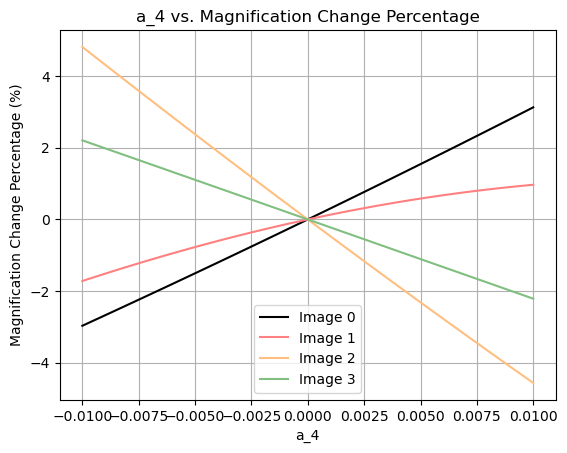

In [15]:
plt.figure()
plt.grid(True)
for i in range(4):
    mag_change_ratio = (mag_arr[:,i] - mag_noboxydisky[i])/mag_noboxydisky[i]
    mag_change_percent = mag_change_ratio*100
    plt.plot(a_m_arr, mag_change_percent, label='Image %d'%(i), color=color_arr[i])
plt.xlabel("a_4")
plt.ylabel("Magnification Change Percentage (%)")
plt.title("a_4 vs. Magnification Change Percentage")
plt.legend()
plt.show()

flux ratio

In [16]:
fr_arr = np.zeros([len(a_m_arr), 4-1])
for i in range(3):
    fr_arr[:,i] = mag_arr[:,i+1]/mag_arr[:,0]

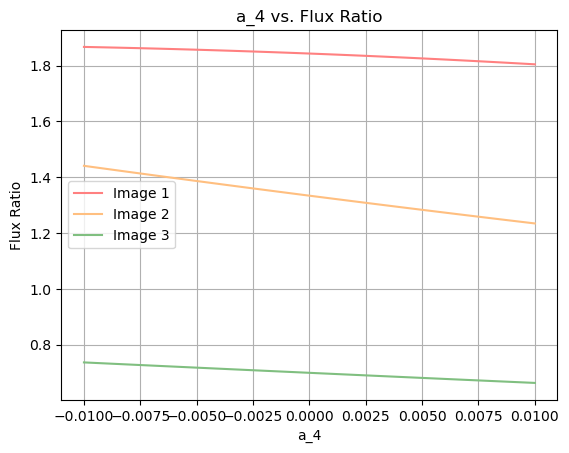

In [18]:
plt.figure()
plt.grid(True)
for i in range(3):
    plt.plot(a_m_arr, fr_arr[:,i], label='Image %d'%(i+1), color=color_arr[i+1])
plt.xlabel("a_4")#fr_change_percent
plt.ylabel("Flux Ratio")
plt.title("a_4 vs. Flux Ratio")
plt.legend()
plt.show()

flux ratio change percentage

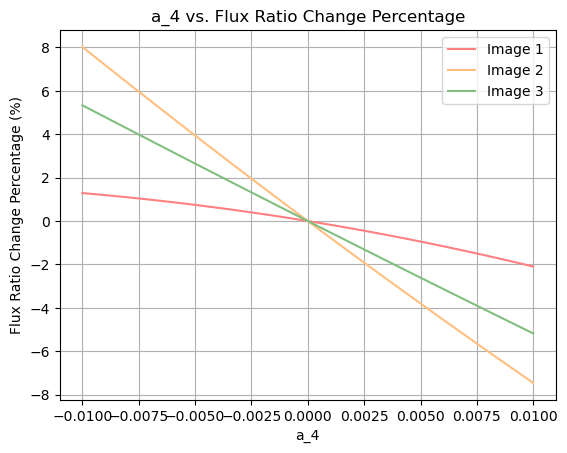

In [19]:
plt.figure()
plt.grid(True)
for i in range(3):
    fr_change_ratio = (fr_arr[:,i] - fr_noboxydisky[i])/fr_noboxydisky[i]
    fr_change_percent = fr_change_ratio*100
    plt.plot(a_m_arr, fr_change_percent, label='Image %d'%(i+1), color=color_arr[i+1])
plt.xlabel("a_4")
plt.ylabel("Flux Ratio Change Percentage (%)")
plt.title("a_4 vs. Flux Ratio Change Percentage")
plt.legend()
plt.show()

In [20]:
def change_percentage_calc(x_obs, x_std):
    # calculates the difference of x_obs from x_std in percentage
    return 100*(x_obs-x_std)/x_std

% GUI for different setup...

In [21]:
%matplotlib widget
%matplotlib inline
from lenstronomy.Util.param_util import phi_q2_ellipticity

from lenstronomy.Util.param_util import ellipticity2phi_q
phi, q = ellipticity2phi_q(0.1, 0.2)
x_grid = np.linspace(-numPix/2*deltaPix, numPix/2*deltaPix, numPix); y_grid = x_grid
X_grid,Y_grid = np.meshgrid(x_grid, y_grid)

def f(a_m=0., phi_m=phi, q=q):
    
    phi_G = phi_m
    e1, e2 = phi_q2_ellipticity(phi_G, q)
    
    a_m_arr = np.linspace(-0.01, +0.01, 100)
    mag_arr = np.zeros([len(a_m_arr), 4])
    fr_arr = np.zeros([len(a_m_arr), 4-1])
    x_image_arr = np.zeros([len(a_m_arr), 4])
    y_image_arr = np.zeros([len(a_m_arr), 4])

    for i, a_m_val in enumerate(a_m_arr):
        x_image, y_image, mag_val = my_epl_boxydisky_x_y_mag(a_m_val, e1, e2)
        mag_arr[i] = mag_val
        x_image_arr[i] = x_image
        y_image_arr[i] = y_image
        fr_arr[i] = mag_val[1:]/mag_val[0]

    # Standard data without boxy/diskyness
    x_image_noboxydisky, y_image_noboxydisky, mag_noboxydisky = my_epl_boxydisky_x_y_mag(0., e1, e2)
    fr_noboxydisky = mag_noboxydisky[1:]/mag_noboxydisky[0]
    
    fig, axs = plt.subplots(1, 5)
    fig.set_size_inches(25, 5)
    # image_sim, a_4 vs magnification, a_4 vs flux_ratio, a_4 vs x_image, a_4 vs y_image
    _, image_sim, x_image, y_image, mag = my_epl_boxydisky_data(data_class, a_m, e1, e2, noise=False)
    axs[0].pcolormesh(X_grid,Y_grid, np.log10(image_sim), cmap='bwr', shading='auto')
    axs[0].set_title('lensed image')
    axs[0].text(x_image[0], y_image[0], 'A'); axs[0].text(x_image[1], y_image[1], 'B'); axs[0].text(x_image[2], y_image[2], 'C'); axs[0].text(x_image[3], y_image[3], 'D')
    
    # Calculate this time's values
    x_image, y_image, mag = my_epl_boxydisky_x_y_mag(a_m, e1=e1, e2=e2)
    fr = mag[1:]/mag[0]
    
    # a_m vs magnification change percentage
    for i in range(4):
        mag_change_percent = change_percentage_calc(mag_arr[:,i], mag_noboxydisky[i])
        axs[1].plot(a_m_arr, mag_change_percent, label='Image %d'%(i), color=color_arr[i])
        axs[1].plot(a_m, (mag[i]- mag_noboxydisky[i])/mag_noboxydisky[i]*100, 'ko')
    axs[1].set_title('a_4 vs Magnification Change Percentage')
    axs[1].set_xlabel('a_4')
    axs[1].set_ylabel('Magnification Change Percentage (%)')
    axs[1].legend()
    
    # a_m vs flux_ratio change percentage
    for i in range(3):
        fr_change_percent = change_percentage_calc(fr_arr[:,i], fr_noboxydisky[i])
        # print('a_m: ', a_m)
        # print('flux ratio change percentage', (fr[i] - fr_noboxydisky[i])/fr_noboxydisky*100)
        axs[2].plot(a_m_arr, fr_change_percent, label='Image %d'%(i+1), color=color_arr[i+1])
        axs[2].plot(a_m, change_percentage_calc(fr[i], fr_noboxydisky[i]), 'ko')
    axs[2].set_title("a_4 vs. Flux Ratio Change Percentage")
    axs[2].set_xlabel("a_4")
    axs[2].set_ylabel("Flux Ratio Change Percentage (%)")
    axs[2].legend()
    
    # x_image and y_image change
    for i in range(4):
        x_image_change_percent = change_percentage_calc(x_image_arr[:, i], x_image_noboxydisky[i])
        y_image_change_percent = change_percentage_calc(y_image_arr[:, i], y_image_noboxydisky[i])
        axs[3].plot(a_m_arr, x_image_change_percent, color=color_arr[i], label='Image %d'%(i))
        axs[4].plot(a_m_arr, y_image_change_percent, color=color_arr[i], label='Image %d'%(i))
        axs[3].plot(a_m, change_percentage_calc(x_image[i], x_image_noboxydisky[i]), 'ko')
        axs[4].plot(a_m, change_percentage_calc(y_image[i], y_image_noboxydisky[i]), 'ko')
    axs[3].set_title("a_4 vs x_image Change Percentage")
    axs[4].set_title("a_4 vs y_image Change Percentage")
    axs[3].set_xlabel("a_4")
    axs[4].set_xlabel("a_4")
    axs[3].set_ylabel("x_image Change Percentage (%)")
    axs[4].set_ylabel("y_image Change Percentage (%)")
    axs[3].legend()
    axs[4].legend()
    plt.show()
    
    for i in range(len(axs)):
        axs[i].set_aspect('equal', 'box')
    plt.show()
    
    return a_m_arr, mag_arr, fr_arr
    
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interactive_plot = interactive(f, a_m=(-0.01, +0.01, 0.001), phi_m=(-np.pi, +np.pi, 0.05), q=(0,1.0,0.05))
output = interactive_plot.children[-1]
#output.layout.height = '350px'
#output.layout.width = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='a_m', max=0.01, min=-0.01, step=0.001), FloatSlider(…

In [22]:
interactive_plot.kwargs

{'a_m': 0.0, 'phi_m': 0.5535743588970452, 'q': 0.6345120047368864}

# Conclusion

For an example lens configuration, when a_4 changes from -0.01 to +0.01 while the axes are aligned with the smooth lens axes, we can see that

1. The position of the images change by +/- few percents.    *(Meanwhile, percent is not a good measure; what is a better&universal measure?)*

2. The magnification of the images change by +/- few percents.

3. The flux ratios change by +/- few percents. (Here the maximum change is 8%)


# What's Next?

1. (optional) Testing how much flux ratios change in other lensing configurations (different source position, etc.)
1. (optional) Testing phi change (probably not needed)
1. (optional) Testing a_3 (probably not needed)

2. (must) Testing if the right parameters can be inferred from MCMC

    2.1. Using Image Positions -> (Probably) No -> 
    2.2. Using The Full Imaging -> (Hopefully) Yes -> 
    2.3. Showing how much of systematic uncertainties there are if a_4 (or a_3) is ignored.
    
3. (must) Testing more generally (real/realistic data, realistic PSF, etc.)